# Create Label Chips

This notebook demonstrates how to create a series of 3-class labels (non-field (0), field interior (1), and field edge (2)), from the vectorized field boundary data, which can be used for training a boundary-aware semantic segmentation model that can be used to help delineate individual crop fields. 

In this example, labels are made from the highest quality assignment for each site. The resulting chips provide a single label for each image chip. Additional assignments for Class 1 and 4 sites are also available, and can be converted to chips for different purposes (e.g. to assess the impact of label noise on model predictions; Elmes et al, 2020). 

This notebook may also be adapted to create different types of labels, such as binary labels (field/no-field) or separate labels representing, for example, field edge, field interior, non-field, and distance to nearest field boundary.

In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
from datetime import datetime as dt
from makelabels import MakeLabels
from makelabels.utils import view_random_label
import urllib.request

## Set-up

In [2]:
root_dir = os.environ["HOME"]
proj_dir = Path(root_dir) / "projects/lacunalabels"
data_dir = Path(root_dir) / "data/labels"
chip_dir = Path(data_dir) / "lacunalabels/images"
label_dir = Path(data_dir) / "lacunalabels/labels"
final_dir = Path(proj_dir) / "data/processed"
if not os.path.exists(label_dir):
    os.makedirs(label_dir, exist_ok=True)

log_file = Path(root_dir) / "logs/label-maker"

## Selecting a label catalog

The label catalog provided here provides all assingments collected during the project, with the exception of sites where image quality was insufficient to label (note: additional labels may have been retained with low image quality).  Labels are provided in the following classes:

The labels have several distinct classes: 

-   Class 1a: A subset expert-labeled sites that were selected to serve as quality control sites (Q sites) in the labelling platform;

-   Class 1b: Expert-labeled sites not used in the labelling platform for Quality control;

-   Class 1c: Q control assignments completed by the labelling teams against Class 1a labels;

-   Class 1d: Sites corresponding to Class 1b sites that were digitized by 1-3 members of the labeling team;

-   Class 2: Ordinary mapping assignments, represented a single unique site mapped by a single labeller. An exception to this case of one labeller/one label were for those assignment marked as Untrusted, in which case it would have been mapped multiple times until the first approved assignment was completed. 

-   Class 4: Sites mapped by three separate labellers

The catalog provides a range of quality metrics associated with the labels, with the following exceptions; 

- For Class 1a and 1b, no Qscores are available
- For Class 1b, there are 153 sites for which no Rscore is available

All labels are preserved in the catalog, as they may be useful for different purposes, such as: 

- Contructing quality-weighted consensus maps to:
    1. Assess label uncertainty;
    2. Extract pixel-based samples from area of higher certainty
- Testing whether additional noisy labels added to training samples improve model performance;
- Pass multiple labels for the same location into a model as a form of data-based regularization

We provided an example here of one approach for selecting what is likely to be the best label for each site, using the following rules:

- Drop:
    - All assignments marked as Untrusted or Rejected;
    - No Class 1c labels;
- Keep:
    - All Class 1a assignments;
    - All Class 2 assignments;
    - The assignment with the highest Rscore for each site occuring in one or both of the Class 1b and Class 1d samples;
    - The assignment with the highest Rscore for each Class 4 site

Alternative approaches may also be used for finding the best sample, such as using the highest Qscore per sample, or multiple individual Q metrics, e.g. the highest combination of Area and N metrics. It may also be preferrable to take the Class 1c assignment with the highest Qscore or highest Rscore for each Class 1a site, in place of the Class 1a labels. 

### Read in catalogs

One containing the assignment details with label Classes, and the other the image chip catalog, to get the image names. We supply a vector of column names to keep, which is used later on in label-making function. 

In [3]:
catalog = pd.read_csv(Path(proj_dir) /\
                      "data/interim/label_catalog_allclasses.csv")
chip_catalog = pd.read_csv(Path(proj_dir) /\
                           "data/interim/image_chip_catalog.csv")

keep = ["name", "Class", "assignment_id", "Labeller", "status", "Score", 
        "N", "Area", "Qscore", "Rscore", "x", "y", "farea", "nflds", "image"]
catalog = pd.merge(catalog, chip_catalog.drop(columns = "image_date"))[keep]
catalog.head()

,name,Class,assignment_id,Labeller,status,Score,N,Area,Qscore,Rscore,x,y,farea,nflds,image
0,ET0007182,2,50,22,Untrusted,NaN,NaN,NaN,0.621788,0.706386,39.5115,14.4825,0.000000,0,ET0007182_2017-08.tif
1,NE3372442,2,51,22,Untrusted,NaN,NaN,NaN,0.621788,0.706386,9.1515,14.4025,0.000000,0,NE3372442_2021-08.tif
2,SN0105655,2,48,13,Untrusted,NaN,NaN,NaN,0.623301,0.728205,-16.3435,15.6325,3.216725,8,SN0105655_2020-02.tif
3,SD4068077,2,52,22,Untrusted,NaN,NaN,NaN,0.621788,0.706386,33.3765,14.3925,6.902422,7,SD4068077_2022-03.tif
4,ML2303293,2,16,22,Untrusted,NaN,NaN,NaN,0.621788,0.706386,-2.3085,16.7775,0.000000,0,ML2303293_2021-04.tif


### Apply filter

To follow the selection example describe above, we first query the catalog to drop Untrusted and Rejected assignments, then define a grouping list with the key for "whole" Classes to be retained set at "1a" and "2", and two separate groups for "best" selection. The first is for Classes "1b" and "1d", which means that if there are multiple assignments for the same site in those classes, the one with the highest metric (here Rscore) is selected. The second is for Class 4, and the same selection process is followed within that Class, picking the single assignment with the highest Rscore.  

Since some sites were mapped in Classes 1a and 1b, a final filtering is applied in which the Class 1a assignments were retained in preference to assignments for the same sites in Class 1b. 

This filtering process is undertaken by a function `filter_catalog` provided by the `MakeLabels` class, which we initialize before running

In [4]:
catalog = catalog.query("status not in ['Untrusted', 'Rejected']")

groups = [
    {"whole": ["1a", "2"]}, # preserve all assignments in these groups
    {"best": ["1b", "1d"]},  # select best assignment for each site from these
    {"best": "4"}  # best assignment from this group
]

mkl = MakeLabels(logfile=log_file)
label_catalog = mkl.filter_catalog(catalog, groups, "Rscore", keep)

# there are some duplicates of Class 1a in Classes 1b/d, so we'll drop those
label_catalog.drop_duplicates("name", inplace=True)

Started dataset creation
Extracting all of Class 1a and 2
Extracting best of Class 1b and 1d
Extracting best of Class 4


The final class counts were as follows

In [5]:
label_catalog.value_counts("Class")

Class
2     30772
4       990
1d      905
1a      797
1b      282
Name: count, dtype: int64

## Making label chips

The next step is to convert the polygons into rasterized label chips. This requires the geoparquet file containing the field polygons. We will use the filtered label catalog to get the image chip that corresponds to the labelled site, and the convert the polygons for each site to a 3-class label that has the same dimensions as the image chip. 

First download the file from Zenodo and save it into the project's data directory, and then read it into a `GeoDataFrame`

In [6]:
url = 'https://zenodo.org/records/11060871/files/mapped_fields_final.parquet'
dst = Path(final_dir) / os.path.basename(url)
# urllib.request.urlretrieve(url, dst)

In [7]:
fields = gpd.read_parquet(dst)

In [8]:
kwargs = {
    "fields": fields,
    "label_dir": label_dir, 
    "chip_dir": chip_dir, 
    "src_col": "image",
    "verbose": False,
    "overwrite": False
}

In [9]:
%%time
catalogf = mkl.run_parallel_threads(
    label_catalog, mkl.threeclass_label, kwargs, 4
)
label_catalog_final = pd.DataFrame(catalogf).reset_index(drop=True)

Completed run
CPU times: user 4h 21min 12s, sys: 16min 20s, total: 4h 37min 32s
Wall time: 1h 16min 2s


In [23]:
label_catalog_final.to_csv(Path(final_dir) / "label-catalog-filtered.csv", 
                           index=False)

## Display labels

The following viewer can be used to display labels against the images

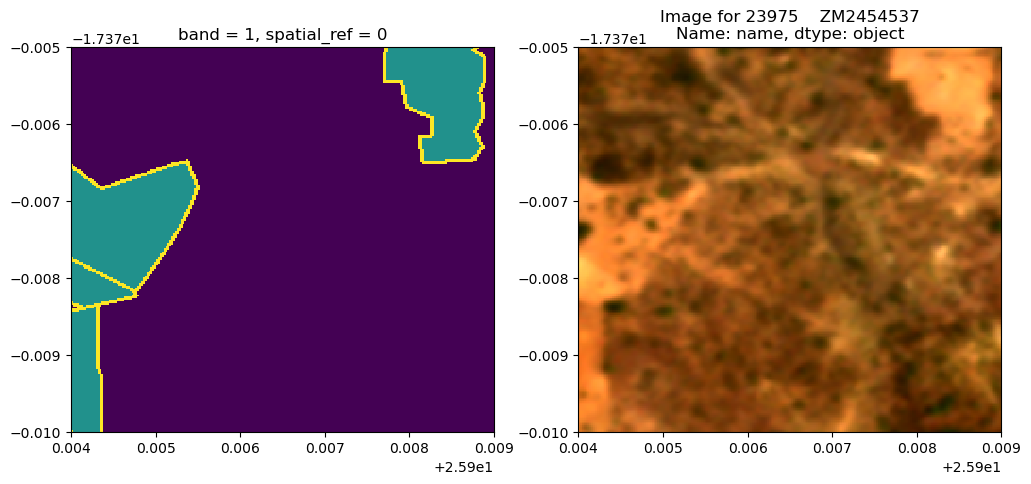

In [21]:
view_random_label(label_catalog_final, label_dir, chip_dir, [2,1,0])

## References

Elmes, A., Alemohammad, H., Avery, R., Caylor, K., Eastman, R., Fishgold, L., Friedl, M. A., Jain, M., Kohli, D., Laso Bayas, J.C., Lunga, D., McCarty, J.L., Pontius Jr, R.G., Reinmann, A.B., Rogan, J., Song, L., Stoynova, H., Ye, S., Yi, Z., Estes, L. (2020). Accounting for training data error in machine learning applied to Earth observations. [*Remote Sensing*, 12, 1034](https://www.mdpi.com/2072-4292/12/6/1034).
